# Constrained Example
## 19-6

In [2]:
%matplotlib inline

from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
  !wget -O basic_material.py https://www.dropbox.com/s/o48uhuwah8n2xww/basic_material.py?dl=0
%run basic_material

print(shutil.which("ipopt"))
from pyomo.environ import *
from pyomo.dae import *

Running Python: 3.8.16
/usr/local/bin/ipopt


In [3]:
# collocation parameters
NFE = 1000
NCP = 3
T = 4
umax = 5
x0 = 0

In [4]:
# create a model object
m = ConcreteModel()

# define the independent variable
m.t = ContinuousSet(bounds=(0, T))

# define control inputs
m.u = Var(m.t, bounds=(0, umax))
m.u[0].fix(umax)

# define the dependent variables
m.x = Var(m.t)
m.x[0].fix(x0)

# define derivatives
m.x_dot = DerivativeVar(m.x)

# define the differential equation as constrainta
m.ode_x = Constraint(m.t, rule=lambda m, t: m.x_dot[t] == m.x[t]+m.u[t])

# define the optimization objective
m.integral = Integral(m.t, wrt=m.t, rule=lambda m, t: m.u[t]**2)
m.obj = Objective(expr = -m.x[T] + m.integral, sense=minimize)

# transform and solve
TransformationFactory('dae.finite_difference').apply_to(m, wrt=m.t, nfe=NFE, scheme='BACKWARD')
#discretizer = TransformationFactory('dae.collocation')
#discretizer.apply_to(m,wrt=m.t,nfe=NFE,ncp=NCP,scheme='LAGRANGE-RADAU')
#discretizer.reduce_collocation_points(m,var=m.u,ncp=1,contset=m.t)
solver = SolverFactory('ipopt')
solver.options['max_iter']= 10000 #number of iterations you wish
solver.solve(m).write()


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2001
  Number of variables: 3001
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.13.4\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.4318661689758301
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


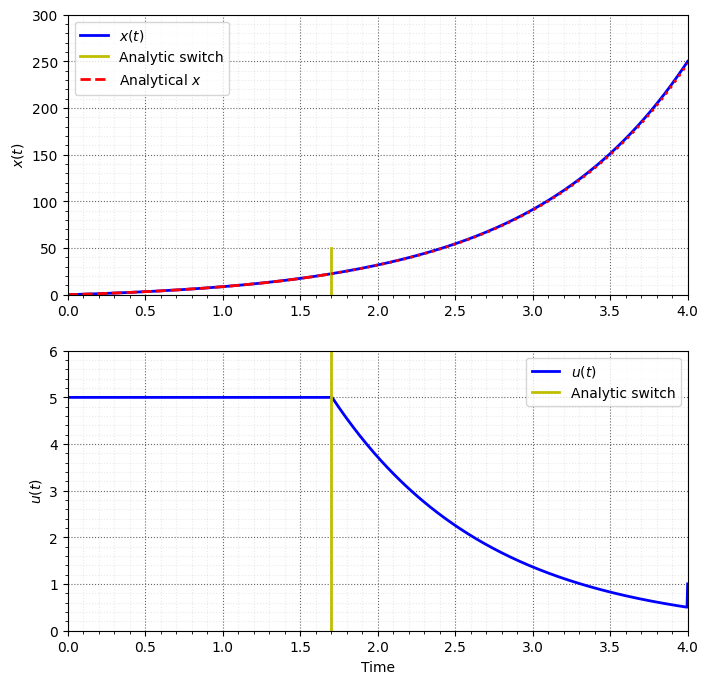

In [5]:
t1 = np.array([t for t in m.t])
x1 = np.array([m.x[t]() for t in m.t])
u1 = np.array([m.u[t]() for t in m.t])
tc = 4 - np.log(10)
t11 = t1[np.where(t1 < tc)]
t12 = t1[np.where(t1 >= tc)]

plt.figure(1,figsize=(8,8))
ax1 = plt.subplot(211)
ax1.plot(t1,x1,'b-',label=r'$x(t)$')
ax1.plot([tc,tc],[0, 50],'y-',label=r'Analytic switch')
ax1.plot(t11,5*np.exp(t11)-5,'r--',label=r'Analytical $x$')
ax1.plot(t12,-0.25*np.exp(4-t12)+(5-25*np.exp(-4))*np.exp(t12),'r:')
#plt.title(r'$K=$ '+str(K)+' $r=$ '+str(r)+' $u_{max}=$ '+str(umax))
plt.ylabel(r'$x(t)$')
plt.ylim([0, 300])
plt.xlim([0, 4])
nicegrid()
plt.legend(loc='best')
ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(t1,u1,'b-',label=r'$u(t)$')
ax2.plot([tc,tc],[0, 250],'y-',label=r'Analytic switch')
plt.ylabel(r'$u(t)$')
plt.xlabel(r'Time')
plt.ylim([0, 6])
plt.xlim([0, 4])
plt.legend(loc='best')
nicegrid()
plt.savefig("figs/fig177.png")
plt.show()